# Intro to Audio Analysis

**Date created:** 2020/10/24<br>
**Last modified:** 2020/10/27<br>
**Description:** Basics you need to know about audio analysis.<br>
**Disclosure:** 
    This tutorial is based on <https://essentia.upf.edu/documentation.html> and <https://github.com/librosa/tutorial>
    as well as inspired by <https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html> and <https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-2.html>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Some Basics about Audio Data




## Audio File?

> Computer-readable audio file formats include (not limited to): 
> - wav (Waveform Audio File) format
> - mp3 (MPEG-1 Audio Layer 3) format
> - WMA (Windows Media Audio) format

> Sound can be represented in the form of acoustic features. An audio signal can be expressed as a function of Amplitude and Time.

<img src="https://books.psychstat.org/rdata/figures/amplitude.png" width="800"></img> </br>

check here for more details: <https://books.psychstat.org/rdata/audio-data.html>

> Sound waves are digitized by sampling them at discrete intervals known as the sampling rate (typically 44.1kHz for CD-quality audio meaning samples are taken 44,100 times per second).

<img src="https://lh3.googleusercontent.com/XMJlFDtiFU7WtZYnPDMDhT6jTFEXvTpY7c7sY70PtTkzEIDm6DvUv5nvHHwbOrUrDckS34aIu5fiZx0615p1-nf3rFxzhza387ud=w2048-rw-v1" width="1000"></img> </br>

Phote credit: <https://deepmind.com/blog/article/wavenet-generative-model-raw-audio>


> In signal processing, sampling is the reduction of a continuous signal into a series of discrete values. The sampling rate is the number of samples taken over some fixed amount of time. A high sampling rate results in less information loss but higher computational expense, and low sampling rate has higher information loss but is fast and cheap to compute.

<img src="https://books.psychstat.org/rdata/figures/wave1.jpg" width="800"></img> </br>



## Let us get it started!!!

Python has some great libraries for audio processing like Librosa and essentia.
We will mainly use these two libraries for this tutorial.

`librosa`: <https://librosa.org/doc/latest/install.html>

`essentia`: <https://essentia.upf.edu/installing.html>

You can use pip or conda to install: `pip install librosa` or `pip install essentia`

In [2]:
import librosa
print(librosa.__version__)

0.6.3


Let us load a example audio file:

In [3]:
y, sr = librosa.load(librosa.util.example_audio_file())
print(len(y), sr)

1355168 22050


Let us play the loaded audio:

In [4]:
import IPython.display as ipd
ipd.Audio(librosa.util.example_audio_file())

In [5]:
print("Let us print the time:",librosa.samples_to_time(len(y), sr))

Let us print the time: 61.45886621315193


Let us visualize the sound wave:

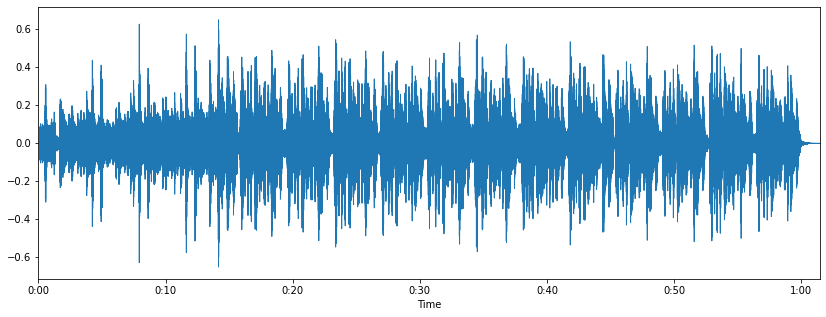

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

### Spectrogram
 
> A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

> A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

We can display a spectrogram using `librosa.display.specshow`.

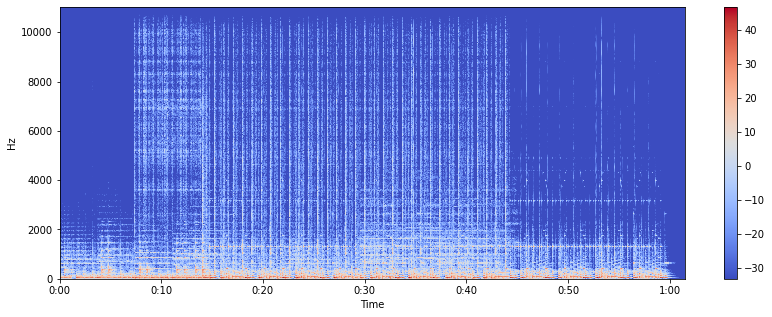

In [7]:
ystft = librosa.stft(y)
ydb = librosa.amplitude_to_db(abs(ystft))
plt.figure(figsize=(14, 5))
librosa.display.specshow(ydb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

> The vertical axis shows frequencies (from 0 to 20kHz), and the horizontal axis shows the time of the clip. Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

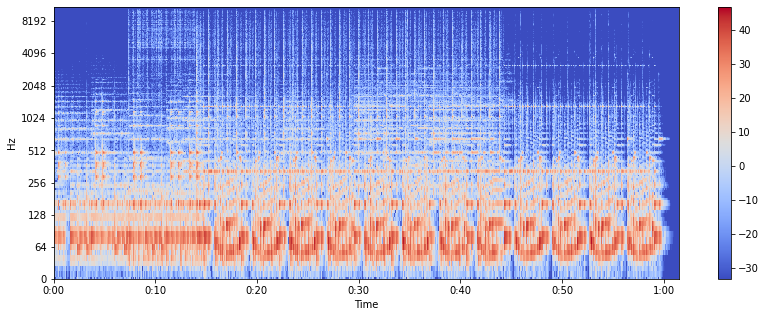

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(ydb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Audio Data Feature extraction
 
> Every audio signal consists of many acoustic features, including spectral features (frequency-based features), which are obtained by converting the time-based signal into the frequency domain using the Fourier Transform, like fundamental frequency, frequency components, spectral centroid, spectral flux, spectral density, spectral roll-off, etc.

#### Mel-Frequency Cepstral Coefficients(MFCCs)

> The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

(20, 2647)


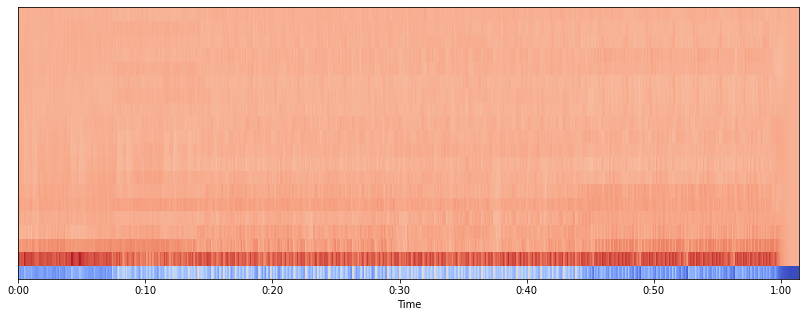

In [9]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print(mfccs.shape)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

#### Zero-Crossing Rate

> A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.

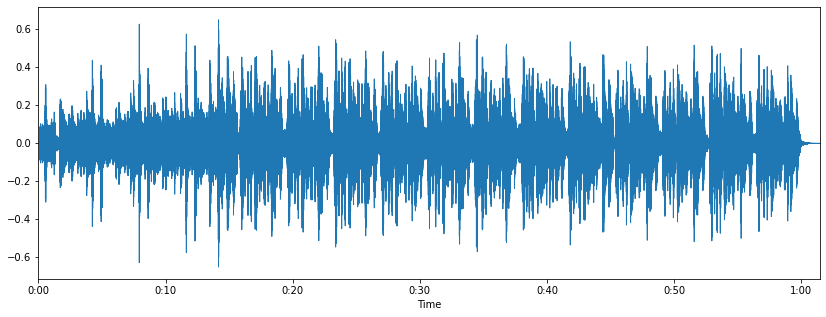

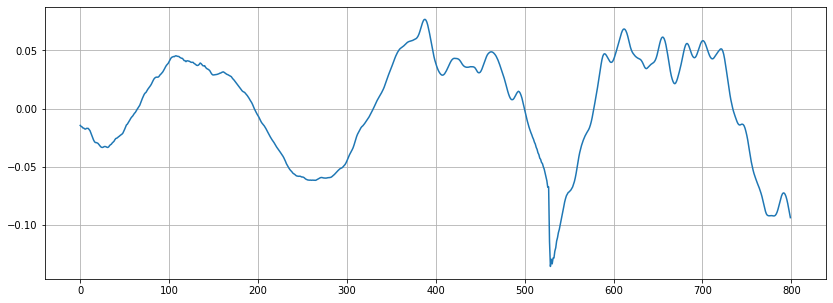

In [10]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)
n0 = 1200
n1 = 2000
plt.figure(figsize=(14, 5))
plt.plot(y[n0:n1])
plt.grid()

In [11]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))#16

6


## Let us use RNN to train a simple speech emotion detection model

This tutorial is insipired by the Kaggle RAVDESS challenge.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations
from sklearn.model_selection import train_test_split
# LSTM Classifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,optimizers,utils

> RAVDESS Dataset Description: We will use Speech audio-only files (16bit, 48kHz .wav) from the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset. This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. for More details: (https://zenodo.org/record/1188976#.X5XeBV7YrBco)

In [13]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

In [16]:
##### load radvess speech dataset #####
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
#subset_dirs_list = ['Actor_01', 'Actor_02', 'Actor_03','Actor_04', 'Actor_05', 'Actor_06','Actor_07', 'Actor_08']

for dirname, dirs, filenames in os.walk('/content/drive/My Drive/SBU/Teaching/SOC591/Slides/Lecture10/Audio_Speech_Actors_01-24/'):
    #dirs[:] = [d for d in dirs if d in subset_dirs_list] # you can remove it to train the model over the entire dataset 
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        radvess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
        wav_file_name = os.path.join(dirname, filename)
        ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [17]:
#### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = utils.to_categorical(ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
ravdess_speech_data_array.shape
labels_categorical.shape

(1440, 8)

In [20]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),
                                                labels_categorical, 
                                                test_size=0.20, 
                                                random_state=2020)

In [21]:
# Split the training, validating, and testing sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [22]:
# Define the LSTM model
def create_model_LSTM():
    model = models.Sequential()
    model.add(layers.LSTM(128, return_sequences=False, input_shape=(40, 1)))
    model.add(layers.Dense(64))
    model.add(layers.Dropout(0.4))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(32))
    model.add(layers.Dropout(0.4))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(8))
    model.add(layers.Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [23]:
### train using LSTM model
model = create_model_LSTM()
history = model.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), 
                    labels_categorical[:training_samples], 
                    validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), 
                                     labels_categorical[training_samples:training_samples+validation_samples]), 
                    epochs=100, 
                    shuffle=True)

Epoch 1/100
36/36 [==============================] - 2s 49ms/step - loss: 2.0878 - accuracy: 0.1293 - val_loss: 2.0771 - val_accuracy: 0.1042
Epoch 2/100
36/36 [==============================] - 1s 35ms/step - loss: 2.0585 - accuracy: 0.1675 - val_loss: 2.0526 - val_accuracy: 0.2014
Epoch 3/100
36/36 [==============================] - 1s 35ms/step - loss: 2.0441 - accuracy: 0.1719 - val_loss: 2.0393 - val_accuracy: 0.1458
Epoch 4/100
36/36 [==============================] - 1s 35ms/step - loss: 2.0261 - accuracy: 0.1875 - val_loss: 1.9996 - val_accuracy: 0.2014
Epoch 5/100
36/36 [==============================] - 1s 35ms/step - loss: 1.9773 - accuracy: 0.2188 - val_loss: 1.9797 - val_accuracy: 0.2222
Epoch 6/100
36/36 [==============================] - 1s 35ms/step - loss: 1.9663 - accuracy: 0.2205 - val_loss: 1.9025 - val_accuracy: 0.3056
Epoch 7/100
36/36 [==============================] - 1s 34ms/step - loss: 1.9334 - accuracy: 0.2300 - val_loss: 1.8523 - val_accuracy: 0.3472
Epoch 

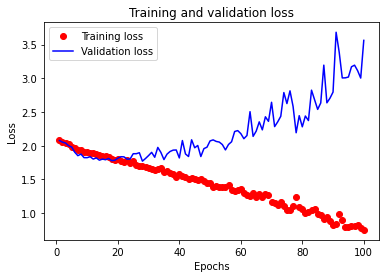

In [24]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

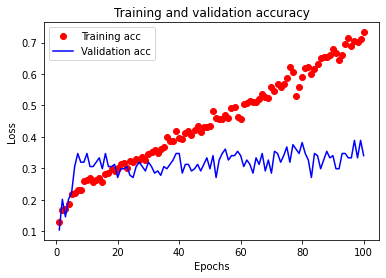

In [25]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
### evaluate using model A
model.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], -1), 
               labels_categorical[training_samples + validation_samples:])

5/5 [==============================] - 0s 9ms/step - loss: 2.7114 - accuracy: 0.3750


[2.7113707065582275, 0.375]

In [27]:
model.save_weights("Model_LSTM.h5")

The model is very simple. You can train a deep network and use the raw spectrogram as input.

## The End